### STEP : Rarefaction Analysis

Using QIIME2 to create rarefaction graphs. List with all [classifiers](https://docs.qiime2.org/2020.6/data-resources/). 


#### Methods
- [qiime feature-classifier](https://docs.qiime2.org/2022.2/plugins/available/feature-classifier/)
- [qiime feature-classifier classify-sklearn](https://docs.qiime2.org/2021.8/plugins/available/feature-classifier/classify-sklearn)
- [qiime metadata](https://docs.qiime2.org/2022.2/plugins/available/metadata/)
- [classify-hybrid-vsearch-sklearn](https://docs.qiime2.org/2022.2/plugins/available/feature-classifier/classify-hybrid-vsearch-sklearn/)
- [qiime metadata tabulate](https://docs.qiime2.org/2022.2/plugins/available/metadata/tabulate/)
- [qiime taxa](https://docs.qiime2.org/2022.2/plugins/available/taxa/)
- [qiime taxa barplot](https://docs.qiime2.org/2022.2/plugins/available/taxa/barplot/)

## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
from qiime2.plugins.diversity.visualizers import beta_rarefaction

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# from qiime2.plugins import demux, deblur, quality_filter, \
#                            metadata, feature_table, alignment, \
#                            phylogeny, diversity, emperor, feature_classifier, \
#                            taxa, composition

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [3]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
replace_files = False

In [4]:
# Parameters
experiment_name = "ana-flavia-HSD-NCxHSD-NR-trim"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri"
manifest_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/manifest/manifest-ana-flavia-HSD-NCxHSD-NR.csv"
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/metadata/metadata-ana-flavia-HSD-NCxHSD-NR.tsv"
class_col = "group-id"
classifier_file = "/home/lauro/nupeb/dados_brutos_rede_genoma/16S_classifiers_qiime2/silva-138-99-nb-classifier.qza"
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = {
    "overlap": 8,
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}


In [5]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))

### Defining names, paths and flags

In [6]:
# QIIME2 Artifacts folder
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Output -Rarefaction Artifacts
alpha_rarefaction_path = os.path.join(qiime_folder, 'alpha-rarefaction.qza')
alpha_rarefaction_view_path = os.path.join(qiime_folder, 'alpha-rarefaction.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(alpha_rarefaction_path)) or replace_files
need_view = not (os.path.isfile(alpha_rarefaction_view_path)) or replace_files

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
#Load Metadata
metadata_qa = Metadata.load(metadata_file)

In [8]:
tabs = Artifact.load(dada2_tabs_path)
tabs_df = tabs.view(Metadata).to_dataframe().T

## Alpha Rarefaction

In [9]:
# Get min and maximum feature counts to set sampling depth
rank_df = tabs_df.sum().sort_values()
min_feature_count = int(rank_df.min())
max_feature_count = int(rank_df.max())

In [10]:
alpha_rar = alpha_rarefaction(
    table = tabs,
    max_depth = max_feature_count,
    min_depth = 1,
    metadata = metadata_qa,
)

In [11]:
alpha_rar.visualization.save(alpha_rarefaction_view_path)
alpha_rar.visualization

<visualization: Visualization uuid: cc5adf44-e979-4d47-9dbd-27b1a5e0183a>

## Beta Rarefaction

/home/lauro/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.004848570911786184 and the largest is 1.514438889076465.
  warn(
/home/lauro/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for mor

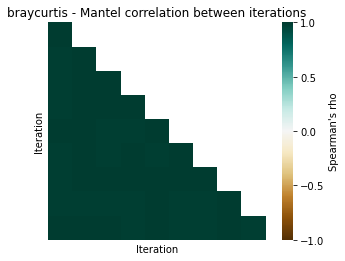

In [12]:
choices = ('matching', 'aitchison', 'euclidean', 'generalized_unifrac', 'canberra', 'russellrao', 'braycurtis', 'cosine', 'jensenshannon', 'yule', 'weighted_normalized_unifrac', 'unweighted_unifrac', 'hamming', 'weighted_unifrac', 'cityblock', 'sokalmichener', 'seuclidean', 'rogerstanimoto', 'correlation', 'minkowski', 'kulsinski', 'chebyshev', 'sqeuclidean', 'sokalsneath', 'jaccard', 'dice', 'canberra_adkins')
clustering_methods = ('nj', 'upgma')
correlation_methods = ('pearson', 'spearman')

sampling_depth = min_feature_count
metric = 'braycurtis'
clustering_method = clustering_methods[0]
correlation_method = correlation_methods[1]

beta_rar = beta_rarefaction(
    table = tabs,
    sampling_depth  = sampling_depth,
    metadata = metadata_qa,
    metric = metric,
    clustering_method = clustering_method,
    correlation_method = correlation_method,
)

In [13]:
plot_tmp = f'{metric}-{clustering_method}-{correlation_method}-{sampling_depth}'
beta_rarefaction_view_path = os.path.join(qiime_folder, f'beta-rarefaction-{plot_tmp}.qzv')
beta_rar.visualization.save(beta_rarefaction_view_path)

beta_rar.visualization

<visualization: Visualization uuid: 374d8da7-265a-41a6-825a-25ccfdc0d01a>